In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.io import imread, imshow
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

from sklearn.preprocessing import normalize
import timm
import pandas as pd

In [7]:
labels=pd.read_csv('labels.csv')

In [8]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [10]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [11]:
labels['breed'].unique()


array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [12]:
categories=labels['breed'].unique()
type(categories)

numpy.ndarray

In [13]:
os.getcwd()

'C:\\Users\\91760\\Projects'

In [14]:
train_path='C://Users//91760//Projects/train/'

In [15]:
filenames = [train_path + fname + ".jpg" for fname in labels['id']]

In [16]:
type(filenames)

list

In [17]:
filenames[:10]

['C://Users//91760//Projects/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'C://Users//91760//Projects/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'C://Users//91760//Projects/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'C://Users//91760//Projects/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'C://Users//91760//Projects/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'C://Users//91760//Projects/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'C://Users//91760//Projects/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'C://Users//91760//Projects/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'C://Users//91760//Projects/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'C://Users//91760//Projects/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

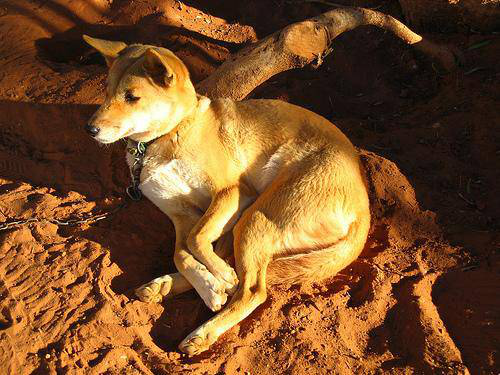

In [18]:
Image.open(filenames[1])

In [19]:
category=labels['breed']

In [20]:
type(category)

pandas.core.series.Series

In [21]:
category.head()

0         boston_bull
1               dingo
2            pekinese
3            bluetick
4    golden_retriever
Name: breed, dtype: object

In [22]:
category.shape

(10222,)

In [23]:
category[1]

'dingo'

In [24]:
category_list=categories.tolist()

In [25]:
category_list.index(category[100])

44

In [26]:
pick_in=open('denseNet161_dog_breed.pickle','rb')
data1=pickle.load(pick_in)
pick_in.close()

In [27]:
pick_in=open('hog_dog_breed.pickle','rb')
data2=pickle.load(pick_in)
pick_in.close()

In [29]:
features_hog=[]
features=[]
labels_new=[]
#labels_hog=[]
for feature,label in data1:
    features.append(feature)
    labels_new.append(label)

for feature,label in data2:
    features_hog.append(feature)
    #labels_hog.append(label)


print(len(features_hog[0]))
print(len(features[0]))
print(len(labels_new))

3780
2208
10222


In [30]:
df=pd.DataFrame(features)
nor=normalize(df)
norm1=pd.DataFrame(nor)
#Removing zero value columns
norm1 = norm1.loc[:, (norm1 != 0).any(axis=0)]

norm2=normalize(features_hog)

In [31]:
#Feature Reduction using PCA

from sklearn.decomposition import PCA
pca=PCA(n_components=0.95)
#px1=pca1.fit_transform(X_4_1)
#px2=pca.fit_transform(X_4_2)
px1=pca.fit_transform(norm1)
px2=pca.fit_transform(norm2)

In [32]:
#Feature Selection Using Mututal Information

from sklearn.feature_selection import SelectPercentile as SP
selector1 = SP(percentile=50) # select features with top 50% MI scores

#selector1.fit(norm1,labels_new)
selector1.fit(px1,labels_new)
#X_4_1 = selector1.transform(norm1)
X_4_1 = selector1.transform(px1)
print(X_4_1.shape, type(X_4_1))

selector2 = SP(percentile=50) # select features with top 50% MI scores
#selector2.fit(norm2,labels_new)
selector2.fit(px2,labels_new)
#X_4_2 = selector2.transform(norm2)
X_4_2 = selector2.transform(px2)
print(X_4_2.shape, type(X_4_2))

(10222, 264) <class 'numpy.ndarray'>
(10222, 487) <class 'numpy.ndarray'>


In [41]:
normed=np.concatenate((norm1,norm2),axis=1)
#normed=np.concatenate((X_4_1,X_4_2),axis=1)
print(normed.shape)

(10222, 5988)


In [43]:
df_new=pd.DataFrame(normed)
df_new['labels']=pd.DataFrame(labels_new)
print(df_new.head())
shuffled = df_new.sample(frac=1,random_state=42).reset_index()
shuffled.drop(shuffled.columns[0],axis=1,inplace=True)
print(shuffled.head())
labels=shuffled.iloc[:,-1]
print(labels.head())
norm=shuffled.drop(shuffled.columns[-1],axis=1)
print(norm.head())

              0             1             2             3             4  \
0  7.760982e-09  6.363548e-09  5.636004e-10  2.447006e-10  1.293943e-07   
1  8.091710e-09  4.907290e-09  1.026784e-09  2.573082e-10  1.148788e-07   
2  7.546026e-09  2.382996e-09  9.662005e-10  2.161556e-10  1.166367e-07   
3  9.768979e-09  2.623525e-09  8.648457e-10  1.805405e-10  9.908634e-08   
4  9.575111e-09  2.363047e-09  7.499593e-10  1.255551e-10  1.676522e-07   

              5             6             7             8             9  ...  \
0  5.965655e-09  1.625327e-09  3.724376e-09  6.666908e-08  2.951289e-08  ...   
1  3.098473e-09  2.820947e-09  1.103476e-08  2.021993e-08  5.053263e-08  ...   
2  4.091971e-09  1.799657e-09  8.314600e-09  6.720061e-08  3.146013e-08  ...   
3  2.579085e-09  3.127820e-09  6.135609e-10  1.115391e-07  2.882521e-08  ...   
4  2.180924e-09  3.387417e-09  8.297410e-09  1.208255e-07  2.913916e-08  ...   

       5979      5980      5981      5982      5983      5984      5

In [44]:
xtrain,xtest, ytrain,ytest=train_test_split(norm,labels,test_size=0.25,random_state=42)

In [45]:
xtrain.shape

(7666, 5988)

In [46]:
xtest.shape

(2556, 5988)

In [47]:
accuracies={}
mean_accuracies={}

In [48]:
# Support Vector Classifier
from sklearn.svm import SVC
model=SVC(C=1,kernel='linear',gamma='auto')
model.fit(xtrain,ytrain)
svc_prediction=model.predict(xtest)
accuracy1=model.score(xtest,ytest)
accuracy_train1=model.score(xtrain,ytrain)

print('Training accuracy', accuracy_train1)

print('Test Accuracy',accuracy1)
print('Prediction is: ',categories[svc_prediction[0]])
cm=confusion_matrix(ytest,svc_prediction)
print(cm)
print(cm.shape)





Training accuracy 0.9746934516044874
Test Accuracy 0.863849765258216
Prediction is:  schipperke
[[23  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0 24 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 18  0]
 [ 0  0  0 ...  0  0 18]]
(120, 120)


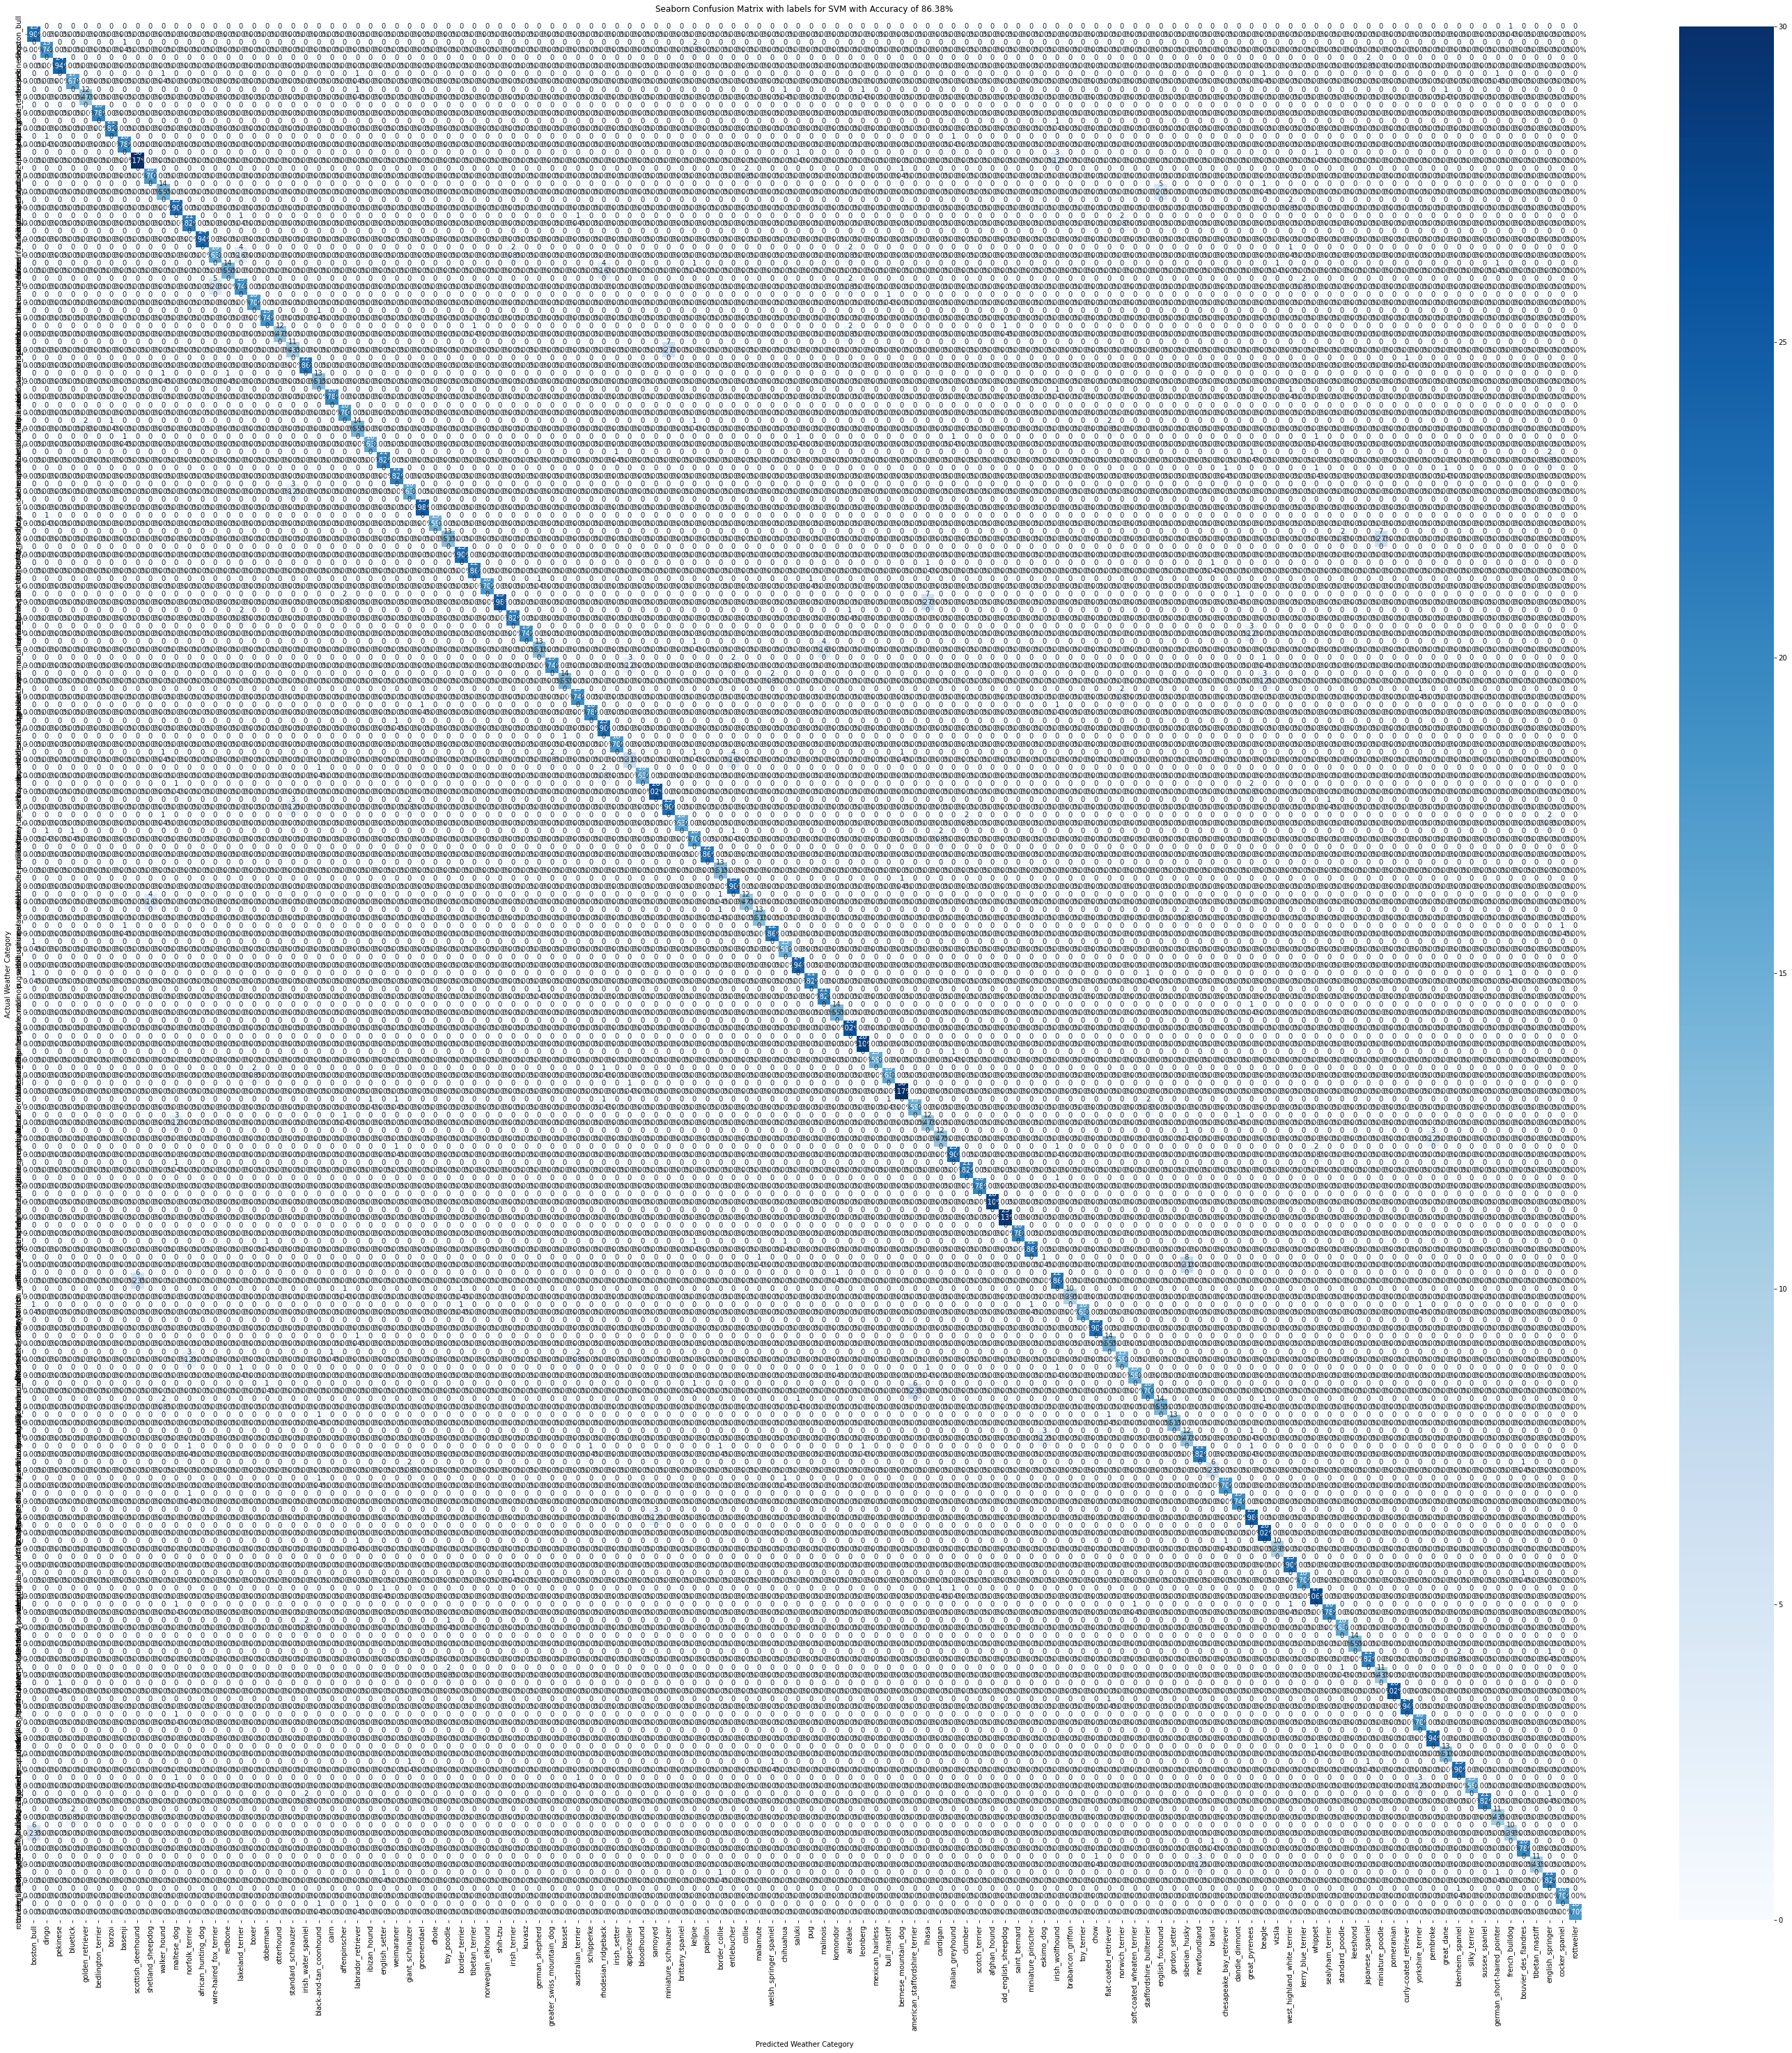

In [49]:
#Confusion Matrix For Support Vector Classifier
import seaborn as sns
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
lab = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]
n=len(categories)
lab = np.asarray(lab).reshape(n,n)
plt.figure(figsize=(50,50))
ax = sns.heatmap(cm, annot=lab, fmt='', cmap='Blues')

ax.set_title(f'Seaborn Confusion Matrix with labels for SVM with Accuracy of {accuracy1*100:.02f}%\n');
ax.set_xlabel('\nPredicted Weather Category')
ax.set_ylabel('Actual Weather Category ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)
## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
#Cross-Validation and Classification Report
from sklearn.model_selection import cross_val_score,cross_val_predict
clf = SVC(kernel='linear', C=1, random_state=42)

#scores = cross_val_score(clf, X, labels_data, cv=5)
scores = cross_val_score(clf, norm, labels, cv=5)

print(scores.mean())
print(scores.max())
accuracies["SVM"]=accuracy1
mean_accuracies["SVM"]=scores.mean()
prediction=cross_val_predict(clf,norm,labels)
#prediction=cross_val_predict(clf,px,labels_resnet)
#prediction=cross_val_predict(clf,X_4,labels_resnet)
cm=confusion_matrix(labels,prediction)
print(cm)

from sklearn.metrics import classification_report

print(classification_report(ytest, svc_prediction, target_names=categories))



0.8559975885052081
0.8679060665362035
